# Question 2. Data Classification with LSTM

In [1]:
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import time
import torch.utils.data as data_utils
from torch.utils.data.dataset import Dataset

#1 Load and Preprocess the Dataset

In [2]:
#****2a******: Loading the dataset
train = pd.read_excel('Train_q2.xlsx')
test = pd.read_excel('Test_q2.xlsx')

In [3]:
#****2a******Add code here: Filter out labels 3,5,6 
def preProcess(matrix):
    m=len(matrix)
    n=len(matrix[0])
    X=[]
    Y=[]
    for i in range(m):
        label = int(matrix[i][-1])
        if label==1:      
            X.append(matrix[i][:-1])
            Y.append(matrix[i][-1]-1)
        elif label==2:      
            X.append(matrix[i][:-1])
            Y.append(matrix[i][-1]-1)
        elif label==4:      
            X.append(matrix[i][:-1])
            Y.append(matrix[i][-1]-2)
    return X,Y

In [4]:
np_train=np.array(train)
py_train=np_train.tolist()
X,y=preProcess(py_train)

np_X=np.array(X)
X=pd.DataFrame(np_X)
np_y=np.array(y)
y=pd.DataFrame(np_y)

np_test=np.array(test)
py_test=np_test.tolist()
X_test,y_test=preProcess(py_test)

np_X_test=np.array(X_test)
X_test=pd.DataFrame(np_X_test)
np_y_test=np.array(y_test)
y_test=pd.DataFrame(np_y_test)

In [5]:
X = X.to_numpy()
X_test = X_test.to_numpy()
y = y.to_numpy()
y_test = y_test.to_numpy()

X_train = torch.from_numpy(X).type(torch.Tensor)   #shape (Batch_size, Sequence_len)
X_test = torch.from_numpy(X_test).type(torch.Tensor) #shape (Batch_size, Sequence_len)
y_train = torch.from_numpy(y).type(torch.Tensor).view(-1, 1) % 6  #(Batch_size, 1)
y_test = torch.from_numpy(y_test).type(torch.Tensor).view(-1, 1) % 6 #(Batch_size, 1)

In [6]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
class Model(nn.Module):
        def __init__(self,input_size=561,hidden_size=50,batch_size=1,output_size=3,num_layers=1):
            super(Model, self).__init__()
            #561=3*11*17
            self.hidden_size = hidden_size
            self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
            self.fc = nn.Linear(hidden_size, output_size)
        
        def forward(self, x, hidden):
            #****2b******Add code here 
            batch_size=1
            lstm_out, (h,c) = self.lstm(x,hidden)
            lstm_out=lstm_out.view(-1,self.hidden_size)
            model_output=self.fc(lstm_out)
            model_output=F.softmax(model_output,dim=1)
            return model_output, (h,c)


# The LSTM Model

In [8]:
batch_size = 1

# Load the Data into Dataloader

In [9]:
import torch
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD

class myloader(Dataset):
    def __init__(self,data,label):
        self.data=data
        self.label=label
    
    def __getitem__(self,index):
        mylabel=self.label[index]
        mydata=self.data[index]
        return mydata,mylabel
    
    def __len__(self):
        return len(self.data)
    
train_data=myloader(X_train,y_train)
test_data=myloader(X_test,y_test)
train_loader=torch.utils.data.DataLoader(train_data,batch_size=batch_size,shuffle=True)
test_loader=torch.utils.data.DataLoader(test_data,batch_size=batch_size,shuffle=True)

In [10]:
model = Model()
# model = model.to(device)
# model=model.double()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
print(model)

Model(
  (lstm): LSTM(561, 50, batch_first=True)
  (fc): Linear(in_features=50, out_features=3, bias=True)
)


In [11]:
loss_list=[]
n_epochs =200

train_losses = []

for epoch in range(n_epochs):
    model.train()
    
    #the first 1 is the batch_size, 1*1*561 should be the output of X_train.view(1,-1,561)
    x=X_train.view(1,-1,561)
    prediction,(h,c)=model(x,None) 
    
    # computing the training loss
    #3585 is the number of data we should process
    actual = y_train.view(3585)
    actual = actual.type(torch.long)

    loss_train = criterion(prediction, actual)
    train_losses.append(loss_train)
    #tr_loss.append(loss_train.item())

    # clearing the Gradients of the model parameters
    optimizer.zero_grad()

    # computing the updated weights of all the model parameters
    loss_train.backward()
    optimizer.step()
        

## Plot Training and Loss Plots

Text(0, 0.5, 'Loss Value')

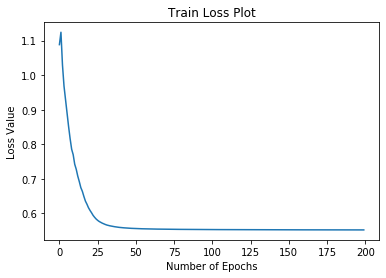

In [12]:
#****2d****** Plot the training losses or accuracies, this has been done for you below
plt.plot(train_losses)
plt.title('Train Loss Plot')
plt.xlabel('Number of Epochs')
plt.ylabel('Loss Value')

In [13]:
from sklearn.metrics import accuracy_score

with torch.no_grad():
    output,(h,c) = model(X_test.view(1,-1,561),None)
    
softmax = torch.exp(output).cpu()
prob = list(softmax.numpy())
pred = np.argmax(prob, axis=1)
label=list(np_y_test.astype(int))

# for val in predictions:
#     print(val,end='')

# accuracy on training set
accuracy_score(pred,label)

0.9938271604938271

#Calculate the test performance

In [14]:
# for val in pred:
#     print(val,end='')
# print()
# for ele in label:
#     print(ele,end='')
confusion_matrix=[[0]*3 for _ in range(3)]

for i in range(len(pred)):
    confusion_matrix[label[i]][pred[i]]+=1

print(confusion_matrix)

[[490, 6, 0], [1, 470, 0], [0, 2, 489]]
